Weather Forecast

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from zipfile import ZipFile
import os
import numpy as np
from torchvision.datasets.utils import download_url
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from collections import OrderedDict

DataSource 

We will be using data from  Max-Planck-Institute for Biogeochemistry at https://www.bgc-jena.mpg.de/wetter/ and as per documentation at https://www.bgc-jena.mpg.de/wetter/Weatherstation.pdf we get the following metadata about Weather Data table

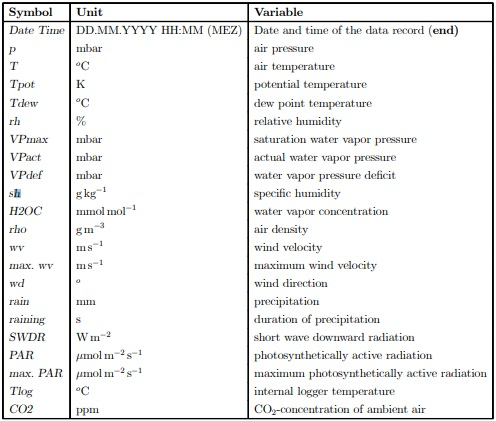

In [2]:
dataset_url = "https://github.com/amandatta16/WeatherPrediction/blob/main/Dataset/WeatherDataSet2009To2019.zip?raw=true"
download_url(dataset_url, './data','WeatherDataSet2009To2019.zip' )
df = pd.read_csv('./data/WeatherDataSet2009To2019.zip')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
0,01.01.2009 00:00:00,996.50,-7.78,265.65,-8.62,93.6,3.40,3.18,0.22,1.99,3.19,1306.51,0.66,1.00,185.5,0.0,0.0,0.0,0.0,0.0,7.23,431.7
1,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3,0.0,0.0,0.0,0.0,0.0,7.20,434.4
2,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1,0.0,0.0,0.0,0.0,0.0,7.15,436.2
3,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6,0.0,0.0,0.0,0.0,0.0,7.09,435.1
4,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0,0.0,0.0,0.0,0.0,0.0,7.38,427.1


If we closely monitor the data above, in column Date Time, data is getting recorded after timestamp of 10 minutes that means sensor records data 6 times in an hour.
That means in a day or 24 hours 24 * 6 = 144 readings in a day.

Now we will use past 4 days readings or 144 * 4 = 576 timestamp to predict data of next day that means after 24 hours = 24 * 6 = 144 readings

so for a input variable of 576 reading the target label will stand at 576 + 144 = 720 readings
so 
for each i
    X[i+0:i+576] should predict Y[i+720]

Preparing dataset


In [3]:
od = OrderedDict()
od["p (mbar)"] = "Pressure"
od["VPmax (mbar)"] = "Saturation vapor pressure"
od["VPdef (mbar)"] = "Vapor pressure deficit"
od["sh (g/kg)"] = "Specific humidity"
od["rho (g/m**3)"] = "Airtight"
od["wv (m/s)"] = "Wind speed"
od["T (degC)"] = "Temperature"



Selecting the features putting most impact


In [4]:

reqFeatures = [i for i in od]
print(df[reqFeatures].head())


   p (mbar)  VPmax (mbar)  VPdef (mbar)  ...  rho (g/m**3)  wv (m/s)  T (degC)
0    996.50          3.40          0.22  ...       1306.51      0.66     -7.78
1    996.52          3.33          0.22  ...       1307.75      1.03     -8.02
2    996.57          3.23          0.21  ...       1309.80      0.72     -8.41
3    996.53          3.21          0.20  ...       1310.24      0.19     -8.51
4    996.51          3.26          0.19  ...       1309.19      0.34     -8.31

[5 rows x 7 columns]


Visualizing Data

we will plot Temperatue on Y axis against each feature plotted at x axis over entire timeframe 

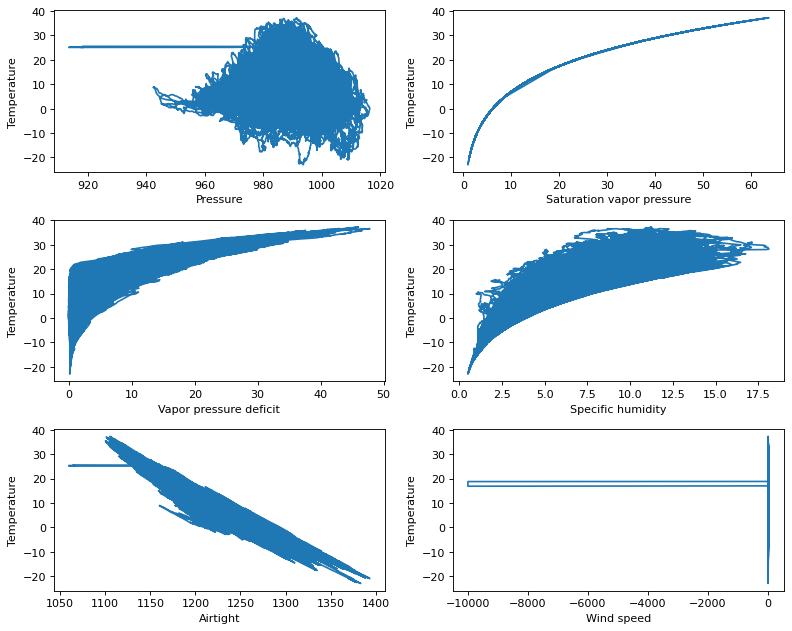

In [5]:
def temperatureToFeatureVisualization(df):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    tempKey = "T (degC)"
    i = 0
    length = len(reqFeatures) - 1
    while i < length:
        key = reqFeatures[i]
        y = df["T (degC)"].to_list()
        x = df[key].to_list()
        axes[i // 2, i % 2].plot(x, y)
        axes[i // 2, i % 2].set(xlabel=od[key], ylabel=od[tempKey])
        i += 1
    fig.tight_layout()
    plt.show()


temperatureToFeatureVisualization(df)

Scale data using minmaxscaler

as we are going to feed the input features to deep learning
model we need to make sure that features value range are uniform so that gradient descent algorithm has smooth descent.

In [6]:
input_features = []

for i in od:
  if i != "T (degC)":
    input_features.append(i)

features = df[input_features]
target = df[["T (degC)"]]
target.index = df["Date Time"]
features.index = df["Date Time"]

print(features.shape[0])
print(target.shape[0])
print(df.head())
print(features.head())
print(target.head())


578189
578189
             Date Time  p (mbar)  ...  Tlog (degC)  CO2 (ppm)
0  01.01.2009 00:00:00    996.50  ...         7.23      431.7
1  01.01.2009 00:10:00    996.52  ...         7.20      434.4
2  01.01.2009 00:20:00    996.57  ...         7.15      436.2
3  01.01.2009 00:30:00    996.53  ...         7.09      435.1
4  01.01.2009 00:40:00    996.51  ...         7.38      427.1

[5 rows x 22 columns]
                     p (mbar)  VPmax (mbar)  ...  rho (g/m**3)  wv (m/s)
Date Time                                    ...                        
01.01.2009 00:00:00    996.50          3.40  ...       1306.51      0.66
01.01.2009 00:10:00    996.52          3.33  ...       1307.75      1.03
01.01.2009 00:20:00    996.57          3.23  ...       1309.80      0.72
01.01.2009 00:30:00    996.53          3.21  ...       1310.24      0.19
01.01.2009 00:40:00    996.51          3.26  ...       1309.19      0.34

[5 rows x 6 columns]
                     T (degC)
Date Time                   

In [7]:

inputScaler = MinMaxScaler()
outputScaler = MinMaxScaler()


features = inputScaler.fit_transform(features.values)
target = outputScaler.fit_transform(target.values)


print(len(features))
print(len(target))

578189
578189


In [8]:
split_fraction = 0.815
train_split = int(split_fraction * len(features))
train_split

471224

In [9]:
x_train = features[0 : train_split - 1]
x_val = features[train_split:]
y_train = target[0 : train_split - 1]
y_val = target[train_split:]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

print("#"*100)
print(y_train)
print("#"*100)
print(x_train)
print("#"*100)
print(y_val)
print("#"*100)
print(x_val)

(471223, 6) (471223, 1)
(106965, 6) (106965, 1)
####################################################################################################
[[0.25261237]
 [0.24863161]
 [0.24216288]
 ...
 [0.39724664]
 [0.39542213]
 [0.39392934]]
####################################################################################################
[[0.80649869 0.03900032 0.00460155 0.08451503 0.73950133 0.99722463]
 [0.80669326 0.03788602 0.00460155 0.08167896 0.74321291 0.99726153]
 [0.80717969 0.03629417 0.00439239 0.07884288 0.74934898 0.99723061]
 ...
 [0.85309855 0.0889844  0.02991006 0.15201361 0.63054865 0.99727649]
 [0.85300126 0.08818848 0.02781845 0.15371526 0.63192553 0.99726452]
 [0.85309855 0.08739255 0.02551767 0.15598412 0.63318268 0.99722962]]
####################################################################################################
[[0.39210483]
 [0.39011445]
 [0.38878753]
 ...
 [0.38397744]
 [0.38895339]
 [0.39160723]]
#################################################

create data loaders

we need custom dataset for LSTM which uses seq of readings too


In [10]:
class TimeseriesDataset(torch.utils.data.Dataset):   
    def __init__(self, X, y, xSequenceLength, ySequenceLength):
        self.X = X
        self.y = y
        self.xSequenceLength = xSequenceLength
        self.ySequenceLength = ySequenceLength

    def __len__(self):
        return self.X.__len__() - (self.ySequenceLength)

    def __getitem__(self, index):
        #if len(self.X) > (index+self.xSequenceLength) and len(self.y) > (index+self.ySequenceLength-1):
        #print("len(self.X) =",len(self.X), "index =", index, "|", "index :", index, " + ", "self.xSequenceLength :",self.xSequenceLength, " = ", (index+self.xSequenceLength), "| len(self.y) =", len(self.y), "(index+self.ySequenceLength-1)", "| index :", index, " + ", "self.ySequenceLength-1 :", self.ySequenceLength-1, " = ", (index+self.ySequenceLength-1))
        return ((self.X[index:index+self.xSequenceLength]), (self.y[index+self.ySequenceLength-1]))

In [11]:
oneDayReading = 144
xSequenceLength = oneDayReading * 4
ySequenceLength = xSequenceLength + oneDayReading



for x in range(ySequenceLength):
    if x == xSequenceLength - 1:
        print("*************************")
    print(x_train[x], "==", y_train[x])

[0.80649869 0.03900032 0.00460155 0.08451503 0.73950133 0.99722463] == [0.25261237]
[0.80669326 0.03788602 0.00460155 0.08167896 0.74321291 0.99726153] == [0.24863161]
[0.80717969 0.03629417 0.00439239 0.07884288 0.74934898 0.99723061] == [0.24216288]
[0.80679054 0.0359758  0.00418323 0.07827567 0.75066599 0.99717776] == [0.24050423]
[0.80659597 0.03677173 0.00397406 0.08054453 0.74752312 0.99719272] == [0.24382153]
[0.80659597 0.03693091 0.00397406 0.08054453 0.74695441 0.99719072] == [0.24448499]
[0.80649869 0.03788602 0.00397406 0.08281339 0.74354216 0.99717975] == [0.24813402]
[0.80649869 0.03963706 0.0037649  0.08735111 0.73701697 0.99717676] == [0.25526621]
[0.80649869 0.03963706 0.00397406 0.08678389 0.7370469  0.99717776] == [0.25526621]
[0.80649869 0.03836358 0.00439239 0.0833806  0.74147685 0.99718673] == [0.25045613]
[0.80679054 0.03629417 0.00460155 0.07827567 0.74949864 0.99721765] == [0.24183115]
[0.80766612 0.03486151 0.00460155 0.07543959 0.75485648 0.99720369] == [0.23

In [12]:


train_dataset = TimeseriesDataset(x_train, y_train, xSequenceLength, ySequenceLength)
val_dataset = TimeseriesDataset(x_val, y_val, xSequenceLength, ySequenceLength)

batch_size = 256

train_loader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, drop_last=True)
#test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [13]:
dataiter = iter(train_loader)
dataiterVal = iter(val_loader)
sample_x, sample_y = dataiter.next()
sample_x_val, sample_y_val = dataiter.next()
print(sample_x.shape, sample_y.shape)
print("here")
print(sample_x[0], "==", sample_y[0])
print("here")
print(sample_x_val.shape, sample_y_val.shape)

torch.Size([256, 576, 6]) torch.Size([256, 1])
here
tensor([[0.8065, 0.0390, 0.0046, 0.0845, 0.7395, 0.9972],
        [0.8067, 0.0379, 0.0046, 0.0817, 0.7432, 0.9973],
        [0.8072, 0.0363, 0.0044, 0.0788, 0.7493, 0.9972],
        ...,
        [0.6965, 0.0724, 0.0079, 0.1548, 0.6020, 0.9973],
        [0.6964, 0.0723, 0.0082, 0.1548, 0.6023, 0.9973],
        [0.6958, 0.0720, 0.0079, 0.1543, 0.6027, 0.9973]], dtype=torch.float64) == tensor([0.1737], dtype=torch.float64)
here
torch.Size([256, 576, 6]) torch.Size([256, 1])


Creating Model

In [14]:
class WeatherNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        super(WeatherNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_size)
        
        
    def forward(self, x, hidden):
        x = x.float() 
        batch_size = x.size(0)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = (lstm_out[:, xSequenceLength-1, :])
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden


initialize model

In [15]:
input_size = 6
output_size = 1
hidden_dim = 64
n_layers = 1
model = WeatherNet(input_size, output_size, hidden_dim, n_layers)
print(model)

WeatherNet(
  (lstm): LSTM(6, 64, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [16]:
lr=0.005
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model.parameters())


<generator object Module.parameters at 0x7fd8dcde9ed0>


Start training

In [27]:
epochs = 1#3
counter = 0
print_every = 1000
clip = 5
valid_loss_min = np.Inf

model.train()
history = []
for i in range(epochs):
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        optimizer.zero_grad()
        output, h = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float().squeeze())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        

        if counter%print_every == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = tuple([each.data for each in val_h])
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab.float().squeeze())
                val_losses.append(val_loss.item())
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            history.append(np.mean(val_losses))
            
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

        

Epoch: 1/1... Step: 1000... Loss: 0.010800... Val Loss: 0.008455
Validation loss decreased (inf --> 0.008455).  Saving model ...


In [ ]:
print(history)

[0.007436990882080525]


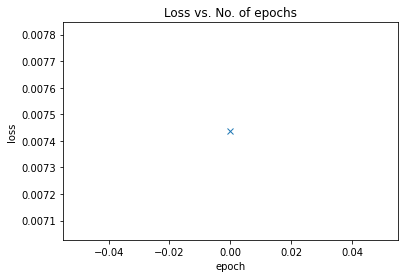

In [ ]:
def plot_losses(history):
    losses = [x for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

Checking unseen data from https://www.bgc-jena.mpg.de/wetter/weather_data.html,
For that We have to feed the model past 120 days of data gets its output and compare it with 121st day and plot the same



In [32]:
dataset_url = "https://github.com/amandatta16/WeatherPrediction/blob/main/Dataset/single_2021.csv.zip?raw=true"
download_url(dataset_url, './data','single_2021.csv.zip' )
zip_file = ZipFile('./data/single_2021.csv.zip')
zip_file.extractall()
df = pd.read_csv('./data/single_2021.csv.zip', encoding = "ISO-8859-1")
df.head()
print(df.shape[0])

Using downloaded and verified file: ./data/single_2021.csv.zip
5387


In [33]:
input_features = []
for i in od:
  if i != "T (degC)":
    input_features.append(i)
features = df[input_features]
output = df[["T (degC)"]]
output.index = df["Date Time"]
features.index = df["Date Time"]
print(features.head())
print(output.head())

                     p (mbar)  VPmax (mbar)  ...  rho (g/m**3)  wv (m/s)
Date Time                                    ...                        
01.01.2021 00:10:00    978.24          7.06  ...       1235.72      1.02
01.01.2021 00:20:00    978.24          7.04  ...       1235.93      1.56
01.01.2021 00:30:00    978.26          7.00  ...       1236.34      2.08
01.01.2021 00:40:00    978.25          6.95  ...       1236.77      2.63
01.01.2021 00:50:00    978.26          6.87  ...       1237.43      2.16

[5 rows x 6 columns]
                     T (degC)
Date Time                    
01.01.2021 00:10:00      2.01
01.01.2021 00:20:00      1.96
01.01.2021 00:30:00      1.88
01.01.2021 00:40:00      1.78
01.01.2021 00:50:00      1.62


In [34]:
features = inputScaler.transform(features.values)
print(np.squeeze(output.values[712:725]))
output = outputScaler.transform(output.values)
print(features)
print("################")
print(output)

output = outputScaler.inverse_transform(output)
print("################")
print(np.squeeze(output[712:725]))

[0.1  0.08 0.05 0.05 0.07 0.14 0.17 0.2  0.18 0.17 0.19 0.3  0.18]
[[0.62885495 0.09726202 0.02740013 0.17923993 0.52761232 0.99726053]
 [0.62885495 0.09694365 0.02656348 0.17980715 0.52824089 0.99731438]
 [0.62904952 0.09630691 0.02551767 0.18037436 0.52946811 0.99736624]
 ...
 [0.61640237 0.04998408 0.00669316 0.10833806 0.62734592 0.99733533]
 [0.61708337 0.05030245 0.00690232 0.10833806 0.62692688 0.99736724]
 [0.61747252 0.05078001 0.00711148 0.10890528 0.62560987 0.99746896]]
################
[[0.41499419]
 [0.41416487]
 [0.41283795]
 ...
 [0.2927517 ]
 [0.29358103]
 [0.29523967]]
################
[0.1  0.08 0.05 0.05 0.07 0.14 0.17 0.2  0.18 0.17 0.19 0.3  0.18]


In [35]:
model.load_state_dict(torch.load('./state_dict.pt'))
predict_dataset = TimeseriesDataset(features, output, xSequenceLength, ySequenceLength)
print("((((((()))))))", predict_dataset.__getitem__(0))
predict_loader = DataLoader(predict_dataset, shuffle=False, batch_size=batch_size, drop_last=True)

predicted = []
actuals = []
h = model.init_hidden(batch_size)
for inputs, actual in predict_loader:
    print(inputs)
    print(actual)
    h = tuple([e.data for e in h])
    out, h = model(inputs, h)
    predicted.append(out.detach().numpy())
    actuals.append(actual.detach().numpy())
    break



((((((())))))) (array([[0.62885495, 0.09726202, 0.02740013, 0.17923993, 0.52761232,
        0.99726053],
       [0.62885495, 0.09694365, 0.02656348, 0.17980715, 0.52824089,
        0.99731438],
       [0.62904952, 0.09630691, 0.02551767, 0.18037436, 0.52946811,
        0.99736624],
       ...,
       [0.72750268, 0.07911493, 0.        , 0.18377765, 0.59906013,
        0.99756569],
       [0.7273081 , 0.07911493, 0.        , 0.18321044, 0.59929959,
        0.99755472],
       [0.72789182, 0.07927412, 0.        , 0.18377765, 0.59917986,
        0.99751583]]), array([0.2]))
tensor([[[0.6289, 0.0973, 0.0274, 0.1792, 0.5276, 0.9973],
         [0.6289, 0.0969, 0.0266, 0.1798, 0.5282, 0.9973],
         [0.6290, 0.0963, 0.0255, 0.1804, 0.5295, 0.9974],
         ...,
         [0.7275, 0.0791, 0.0000, 0.1838, 0.5991, 0.9976],
         [0.7273, 0.0791, 0.0000, 0.1832, 0.5993, 0.9976],
         [0.7279, 0.0793, 0.0000, 0.1838, 0.5992, 0.9975]],

        [[0.6289, 0.0969, 0.0266, 0.1798, 0.5282, 0.

In [29]:
print(len(predicted))
print(len(actuals))
x1 = predicted[0]
print(x1.shape)
x1 = x1.reshape(-1,1)
print(x1.shape)
x2 = (actuals[0])
print(x2.shape)





1
1
(256,)
(256, 1)
(256, 1)


In [30]:
#x2 = scaler2.inverse_transform(x2)
x1 = outputScaler.inverse_transform(x1)


In [31]:
for x in range(len(x1)):
  print("Actual = ", x2[x], " and predicted =", x1[x])

Actual =  [0.2]  and predicted = [6.008112]
Actual =  [0.18]  and predicted = [5.8103333]
Actual =  [0.17]  and predicted = [6.072958]
Actual =  [0.19]  and predicted = [6.0571804]
Actual =  [0.3]  and predicted = [5.084726]
Actual =  [0.18]  and predicted = [6.1464896]
Actual =  [0.1]  and predicted = [4.8854017]
Actual =  [0.1]  and predicted = [5.3300157]
Actual =  [0.14]  and predicted = [5.544724]
Actual =  [0.25]  and predicted = [6.1322355]
Actual =  [0.28]  and predicted = [4.7863507]
Actual =  [0.32]  and predicted = [5.5585284]
Actual =  [0.28]  and predicted = [5.623484]
Actual =  [0.28]  and predicted = [5.5782537]
Actual =  [0.29]  and predicted = [4.9220076]
Actual =  [0.35]  and predicted = [5.470682]
Actual =  [0.42]  and predicted = [4.462477]
Actual =  [0.4]  and predicted = [5.040694]
Actual =  [0.38]  and predicted = [6.752867]
Actual =  [0.37]  and predicted = [5.6144657]
Actual =  [0.3]  and predicted = [5.5962877]
Actual =  [0.34]  and predicted = [6.5120125]
Act